# Assignment 4

*ZM MW*

Schelling's segregation model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio
import os
import shutil
import random

In [40]:
class Schelling:
    
    def __init__(self, empty_ratio=0.5, grid_width=20, grid_length=20, race_prop=0.5, m_t=1, happiness_ratio1=0.5, happiness_ratio2=0.5):
        self.empty_ratio = empty_ratio
        self.grid_width = grid_width
        self.grid_length = grid_length
        self.race_prop = race_prop   # possible to change race proportion
        self.m_t = m_t
        self.happiness_ratio1 = happiness_ratio1  # j_t
        self.happiness_ratio2 = happiness_ratio2  
        self.n_empty = round(self.empty_ratio * self.grid_length * self.grid_width)
        self.n_populated = self.grid_length * self.grid_width - self.n_empty   # calculated basing on empty_ratio
        self.n_race1 = round(self.race_prop * self.n_populated)  # number of agents of one race
        self.n_race2 = self.n_populated - self.n_race1   # number of agents of the other race
        self.board = np.random.choice([0]*self.n_empty + [1]*self.n_race1 + [2]*self.n_race2, replace=False, size=self.grid_length * self.grid_width)
        self.board = np.reshape(self.board, (self.grid_length, self.grid_width))

        self.previous_step = np.full(self.board.shape, None)
        self.end = False
        
        
    def one_step(self): 
                
        if (~np.all(self.board == self.previous_step)):
            self.previous_step = self.board.copy()
            
            self.pos = np.argwhere(self.board)  # gets locations of non-empty cells
            self.shuffled = random.sample(self.pos.tolist(), len(self.pos))  #shuffles the list of locations
            
            for i,j in self.shuffled:
                loc_x = list(range(i-self.m_t, i+self.m_t+1))  # neighbors localization based on a depth of a neighborhood
                loc_x = [loc - self.grid_length if loc >= self.grid_length else loc for loc in loc_x]  # periodic boubdary condition
                loc_x = [self.grid_length + loc if loc < 0 else loc for loc in loc_x]
                loc_y = list(range(j-self.m_t, j+self.m_t+1))
                loc_y = [loc - self.grid_width if loc >= self.grid_width else loc for loc in loc_y]
                loc_y = [self.grid_width + loc if loc < 0 else loc for loc in loc_y]
                self.neighbors = self.board[:,loc_y][loc_x,:]  # matrix of my neighbors plus me in the middle
                self.me = self.board[i,j]  # my race
                self.neighbors_number = np.count_nonzero(self.neighbors) - 1  # number of my neighbors
                if self.neighbors_number == 0:
                    self.am_i_happy = True   # We can also assume that alone node is unhappy - then we change it to 'False'
                else:
                    self.my_race_neighbors = np.count_nonzero(self.neighbors == self.me) - 1  # number of neighbors of the same race as me
                    self.my_satisfaction = self.my_race_neighbors / self.neighbors_number
                    if self.me == 1:
                        self.am_i_happy = True if self.my_satisfaction > self.happiness_ratio1 else False
                    elif self.me == 2:
                        self.am_i_happy = True if self.my_satisfaction > self.happiness_ratio2 else False
                if self.am_i_happy == False:   # changing my place to randomly chosen empty one if i am not happy
                    self.board[i,j] = 0
                    self.new_loc = random.choice(np.argwhere(self.board == 0))
                    self.board[self.new_loc[0]][self.new_loc[1]] = self.me
            
        else:
            self.end = True   

    def count_satisfaction(self):  # checks the satisfaction for current allocation
        self.satisfaction = []
        for i in range(self.grid_length):
            for j in range(self.grid_width):
                if self.board[i,j] != 0:
                    loc_x = list(range(i-1, i+2))  # the closest neighbors
                    loc_x = [loc - self.grid_length if loc >= self.grid_length else loc for loc in loc_x]  # periodic boubdary condition
                    loc_x = [self.grid_length + loc if loc < 0 else loc for loc in loc_x]
                    loc_y = list(range(j-1, j+2))
                    loc_y = [loc - self.grid_width if loc >= self.grid_width else loc for loc in loc_y]
                    loc_y = [self.grid_width + loc if loc < 0 else loc for loc in loc_y]
                    self.neighbors = self.board[:,loc_y][loc_x,:]  # matrix of my closest neighbors
                    self.me = self.board[i,j]  # my race
                    self.neighbors_number = np.count_nonzero(self.neighbors) - 1  # number of my neighbors
                    if self.neighbors_number == 0:
                        self.my_satisfaction = 1
                    else:
                        self.my_race_neighbors = np.count_nonzero(self.neighbors == self.me) - 1  # number of neighbors of the same race as me
                        self.my_satisfaction = self.my_race_neighbors / self.neighbors_number
                    self.satisfaction.append(self.my_satisfaction)

In [13]:
def animation(time, empty_ratio=0.5, grid_width=20, grid_length=20, race_prop=0.5, m_t=1, happiness_ratio1=0.5, happiness_ratio2=0.5):
    animation_path = "{N}_size_j1={j1}_j2={j2}_m={m}_simulation.gif".format(N = round(grid_width*grid_length*(1-empty_ratio)), j1=happiness_ratio1, j2=happiness_ratio2, m=m_t)

    folder_path = "Schellings_segregation_model"

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)

    frames_path = folder_path + "/{i}.jpg"

    colours = colors.ListedColormap(['white', 'royalblue', 'red'])

    experiment = Schelling(empty_ratio, grid_width, grid_length, race_prop, m_t, happiness_ratio1, happiness_ratio2)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid()
    ax.set_title('Schelling\'s model segregation on a {x}x{y} grid, j1 = {j1}, j2 = {j2}, m = {m}, N = {N}'.format(x=grid_length, y=grid_width, j1=happiness_ratio1, j2=happiness_ratio2, m=m_t, N=experiment.n_populated))

    im = ax.imshow(experiment.board, cmap=colours)
    plt.savefig(frames_path.format(i=0))

    n = 1
    while (time>n) & (experiment.end == False):
        experiment.one_step()
        im.set_array(experiment.board)
        plt.savefig(frames_path.format(i=n))
        n += 1

    with imageio.get_writer(animation_path, mode='I') as writer:
        for i in range(n):
            writer.append_data(imageio.imread(frames_path.format(i=i)))


In [10]:
animation(10000, 0.5, 100, 100, 0.5, 4, 0.5, 0.5)
animation(10000, 0.3, 100, 100, 0.5, 4, 0.5, 0.5)
animation(10000, 0.1, 100, 100, 0.5, 4, 0.5, 0.5)

In [4]:
def number_of_iterations(time, empty_ratio=0.5, grid_width=20, grid_length=20, race_prop=0.5, m_t=1, happiness_ratio1=0.5, happiness_ratio2=0.5):
    experiment = Schelling(empty_ratio, grid_width, grid_length, race_prop, m_t, happiness_ratio1, happiness_ratio2)
    
    n = 1
    while (time>n) & (experiment.end == False):
        experiment.one_step()
        n += 1
        
    return n-2

#### Number of iterations with respect to population size

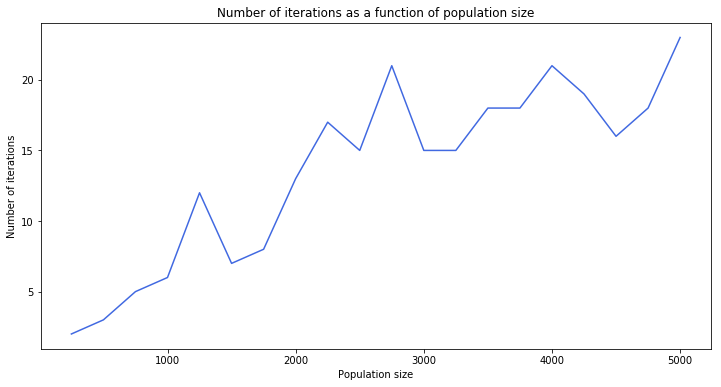

In [5]:
grid_width = 100
grid_length = 100
it = []
N = 250 + 250*np.array(range(20))

for i in N:
    grid_size = grid_width*grid_length
    empty_ratio = (grid_size - i)/grid_size
    it.append(number_of_iterations(10000,float(empty_ratio),grid_width,grid_length))

fig = plt.figure(figsize=(12, 6))
plt.plot(N, it, color='royalblue')
plt.xlabel('Population size')
plt.ylabel('Number of iterations')
plt.title('Number of iterations as a function of population size')
plt.savefig('number_of_iterations.png')
plt.show()


#### Segregation index with respect to happiness ratio

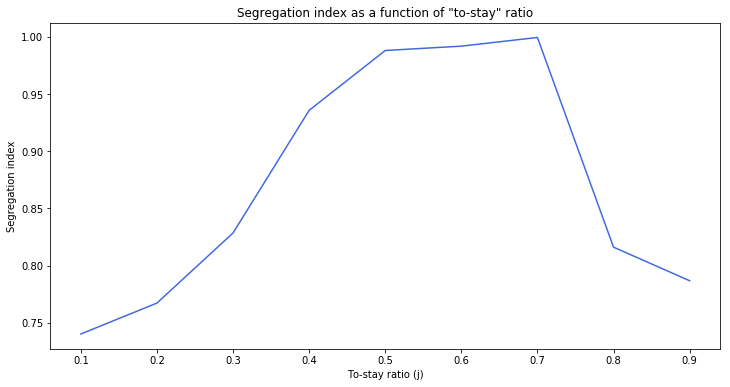

In [42]:
# segregation for j
segregation_index = []
j_t = 0.1 + 0.1*np.array(range(9))  # zmienić na 0.05 i 19 
time = 100  # should be bigger

for j in j_t:
    experiment = Schelling(empty_ratio=0.7, grid_width=100, grid_length=100, race_prop=0.5, m_t=1, happiness_ratio1 = j, happiness_ratio2 = j)
    n = 1
    while (time>n) & (experiment.end == False):
        experiment.one_step()
        n += 1
    experiment.count_satisfaction()
    segregation_index.append(np.mean(experiment.satisfaction))

fig = plt.figure(figsize=(12, 6))
plt.plot(j_t, segregation_index, color='royalblue')
plt.xlabel('To-stay ratio (j)')
plt.ylabel('Segregation index')
plt.title('Segregation index as a function of "to-stay" ratio')
plt.savefig('segregation_and_j.png')
plt.show()    

#### Segregation index with respect to neighborhood depth

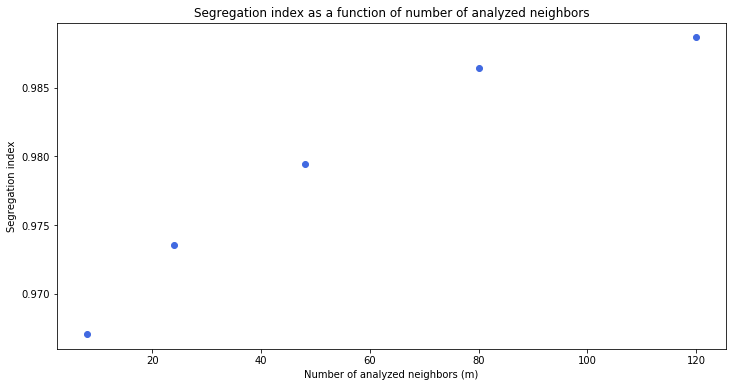

In [50]:
# segregation for m
segregation_index = []
time = 1000
size = np.array(range(1,6))

for m in size:
    experiment = Schelling(empty_ratio=0.5, grid_width=100, grid_length=100, race_prop=0.5, m_t=m, happiness_ratio1 = 0.5, happiness_ratio2 = 0.5)
    
    n = 1
    while (time>n) & (experiment.end == False):
        experiment.one_step()
        n += 1
    experiment.count_satisfaction()
    segregation_index.append(np.mean(experiment.satisfaction))

    
fig = plt.figure(figsize=(12, 6))
plt.plot((2*size+1)**2-1, np.array(segregation_index), 'o', color='royalblue')
plt.xlabel('Number of analyzed neighbors (m)')
plt.ylabel('Segregation index')
plt.title('Segregation index as a function of number of analyzed neighbors')
plt.savefig('segregation_and_m.png')
plt.show()

In [12]:
animation(1000, 0.5, 100, 100, 0.5, 1, 3/8, 3/4)
animation(1000, 0.3, 100, 100, 0.5, 1, 3/8, 3/4)
animation(1000, 0.1, 100, 100, 0.5, 1, 3/8, 3/4)

In [15]:
animation(1000, 0.5, 100, 100, 0.5, 2, 0.2, 0.7)